# INDIAN CLIMATE FORECASTING

The only preprocessing steps taken were to remove impossible values, such as, negative pressure. We did not apply normalisation/standardisation as we doing univariate time series. We should consider it for the next deliverable.

* [Preprocessing](#preprocessing)
* [Exploratory Data Analysis](#eda)
* [Modeling](#modelling)
  * [AR](#ar)
  * [SARIMA](#sarima)
  * [ANN](#ann)
  * [LSTM](#lstm)
* [Testing](#testing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.impute import KNNImputer
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import math

<a id="preprocessing"></a>
# Preprocessing

In [ ]:
test = pd.read_csv('data/DailyDelhiClimateTest.csv')
train = pd.read_csv('data/DailyDelhiClimateTrain.csv')

In [ ]:
train.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [ ]:
train.tail()

date   meantemp    humidity  wind_speed  meanpressure
1457  2016-12-28  17.217391   68.043478    3.547826   1015.565217
1458  2016-12-29  15.238095   87.857143    6.000000   1016.904762
1459  2016-12-30  14.095238   89.666667    6.266667   1017.904762
1460  2016-12-31  15.052632   87.000000    7.325000   1016.100000
1461  2017-01-01  10.000000  100.000000    0.000000   1016.000000

In [ ]:
test.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333

In [ ]:
# We detected that both datasets contain the date 17-01-01. And we decided to remove this date from the training dataset (And keep the row from the testing dataset)
# Additionally, the values of the train dataset seemed to be either filler values or unrealistic. For example, all the features are means. It is unlikely that they
# they all be exact numbers or that the wind speed be zero.

train = train.drop(train[train['date'] == '2017-01-01'].index)

In [ ]:
# Joining datasets to partition the data
dataset = pd.concat([train, test], axis=0)

In [ ]:
# Duplicates detection (there are none)
duplicates = dataset['date'].duplicated()
duplicate_rows = dataset[duplicates]
print(duplicate_rows)


Empty DataFrame
Columns: [date, meantemp, humidity, wind_speed, meanpressure]
Index: []


In [ ]:
# Splitting dataset into train, eval, and test sets
# Train contains 70% of the data while eval and test both contain 15% of the total data
# sort the data by date (assuming there's a 'date' column in the dataset)
dataset = dataset.sort_values(by='date')

dataset['date'] = dataset['date'].apply(pd.to_datetime)

In [ ]:
# Check for NAs (there are none)
print(dataset.isna().any().any())

False


In [ ]:
dataset.describe()

meantemp     humidity   wind_speed  meanpressure
count  1575.000000  1575.000000  1575.000000   1575.000000
mean     25.231582    60.420115     6.903642   1010.589745
std       7.337316    16.956083     4.508803    175.298310
min       6.000000    13.428571     0.000000     -3.041667
25%      18.516667    49.750000     3.700000   1001.875000
50%      27.166667    62.380952     6.370000   1009.000000
75%      31.142857    72.125000     9.262500   1015.183333
max      38.714286    98.000000    42.220000   7679.333333

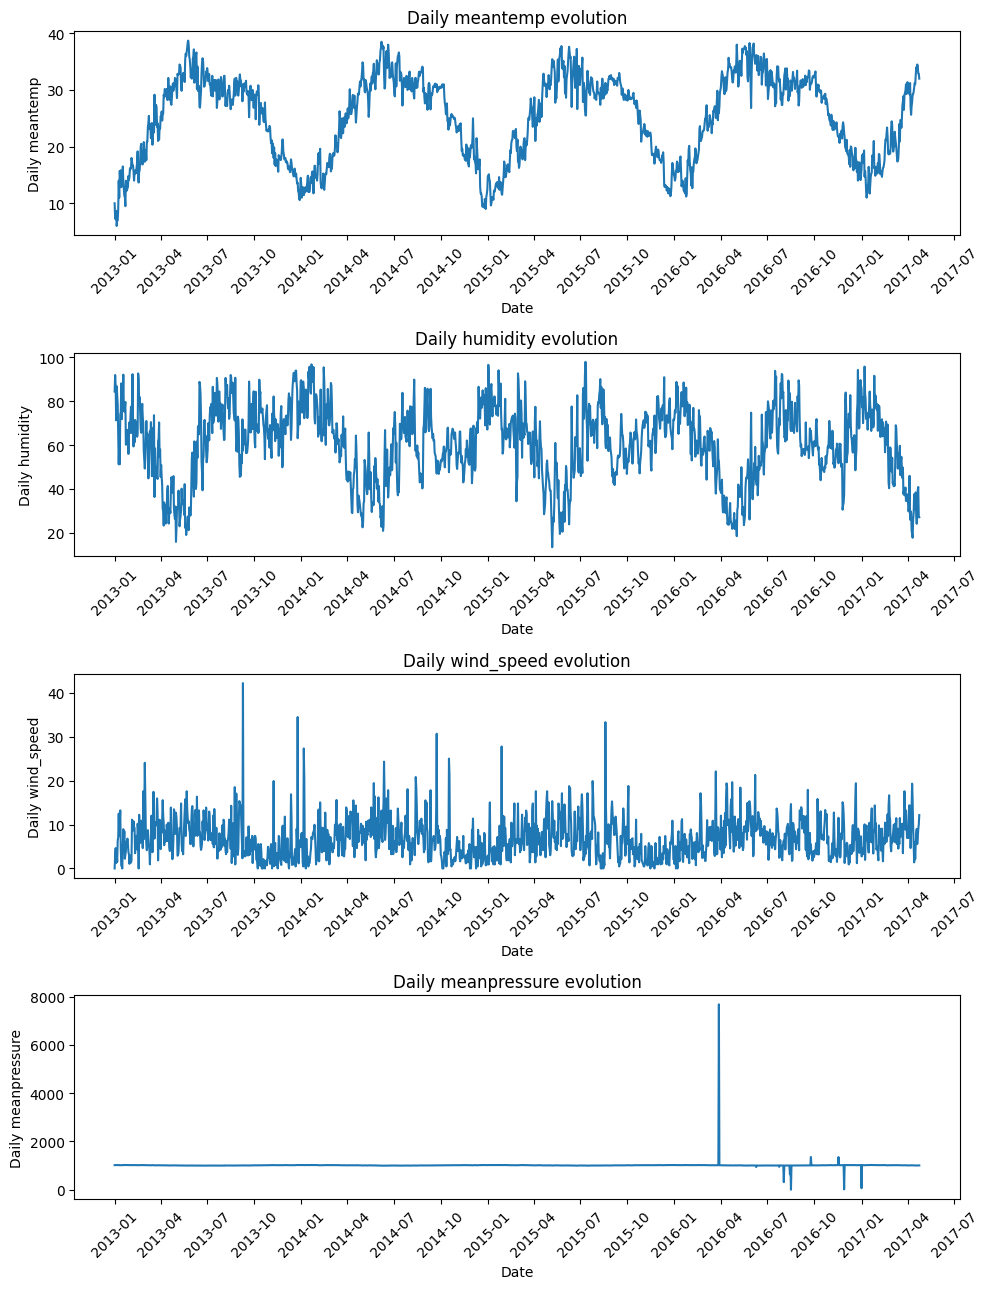

In [ ]:
numerical = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 13))
for i in range(len(numerical)):
    axes[i].plot(dataset['date'], dataset[numerical[i]], label= str(numerical[i]) + ' evolution')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Daily ' + str(numerical[i]))
    axes[i].set_title('Daily ' + str(numerical[i]) + ' evolution')
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[i].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

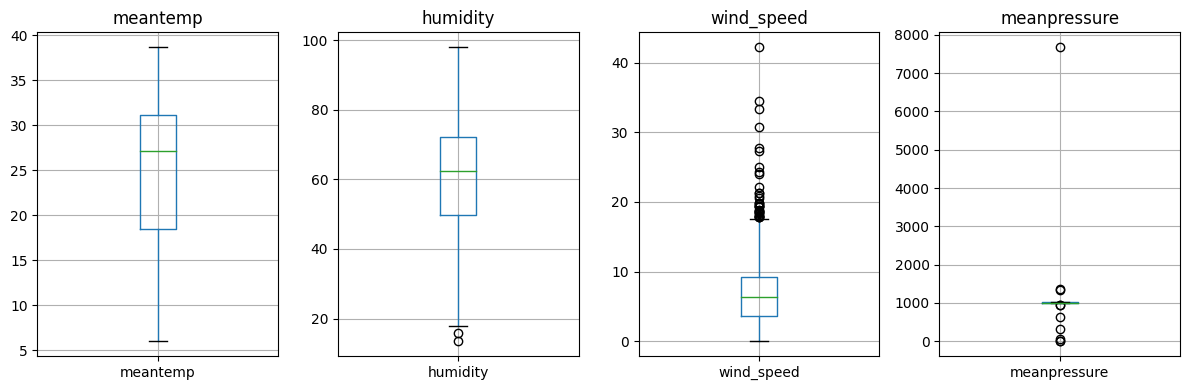

In [ ]:
# Plotting boxplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i in range(len(numerical)):
    dataset.boxplot(column=numerical[i], ax=axes[i])
    axes[i].set_title(numerical[i])
plt.tight_layout()
plt.show()

In [ ]:
# We define a resonable lowest pressure (to remove 2 outliers and an impossible value) and highest recorded value for atmospheric pressure
min_pressure = 980
max_pressure = 1084

dataset.loc[(dataset['meanpressure'] < min_pressure) | (dataset['meanpressure'] > max_pressure), 'meanpressure'] = np.nan

In [ ]:
# Imputation
imputer = KNNImputer(n_neighbors=3)
# imputing missing values
dataset[numerical] = imputer.fit_transform(dataset[numerical])

In [ ]:
# Checking if imputation has been correctly applied
print(dataset.isna().any().any())

False


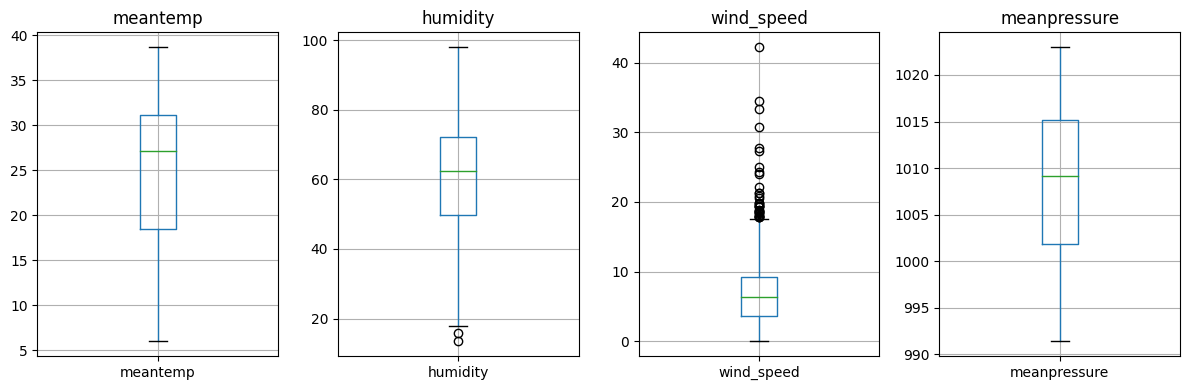

In [ ]:
# Checking outliers again (just in case)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i in range(len(numerical)):
    dataset.boxplot(column=numerical[i], ax=axes[i])
    axes[i].set_title(numerical[i])
plt.tight_layout()
plt.show()

<a id="eda"></a>
#Exploratory Data Analysis


#### Data description

In [ ]:
df_years = dataset.copy()
df_years['year'] = df_years['date'].dt.year

for year in np.unique(df_years['year'].values):
  print(df_years[df_years['year'] == year].describe())
  print()

         meantemp    humidity  wind_speed  meanpressure    year
count  365.000000  365.000000  365.000000    365.000000   365.0
mean    24.791494   63.046292    6.827253   1007.642172  2013.0
std      7.409195   18.191598    4.826612      7.755120     0.0
min      6.000000   15.857143    0.000000    993.250000  2013.0
25%     17.750000   53.000000    3.700000   1000.166667  2013.0
50%     27.166667   66.625000    6.100000   1008.000000  2013.0
75%     30.666667   75.000000    9.275000   1015.285714  2013.0
max     38.714286   94.000000   42.220000   1021.800000  2013.0

         meantemp    humidity  wind_speed  meanpressure    year
count  365.000000  365.000000  365.000000    365.000000   365.0
mean    25.010673   59.767942    6.756148   1008.347166  2014.0
std      7.597334   16.220887    4.661509      7.643039     0.0
min      9.000000   20.875000    0.000000    991.375000  2014.0
25%     18.375000   48.625000    3.250000   1001.875000  2014.0
50%     26.571429   59.875000    6.2500

### Attributes Evolution

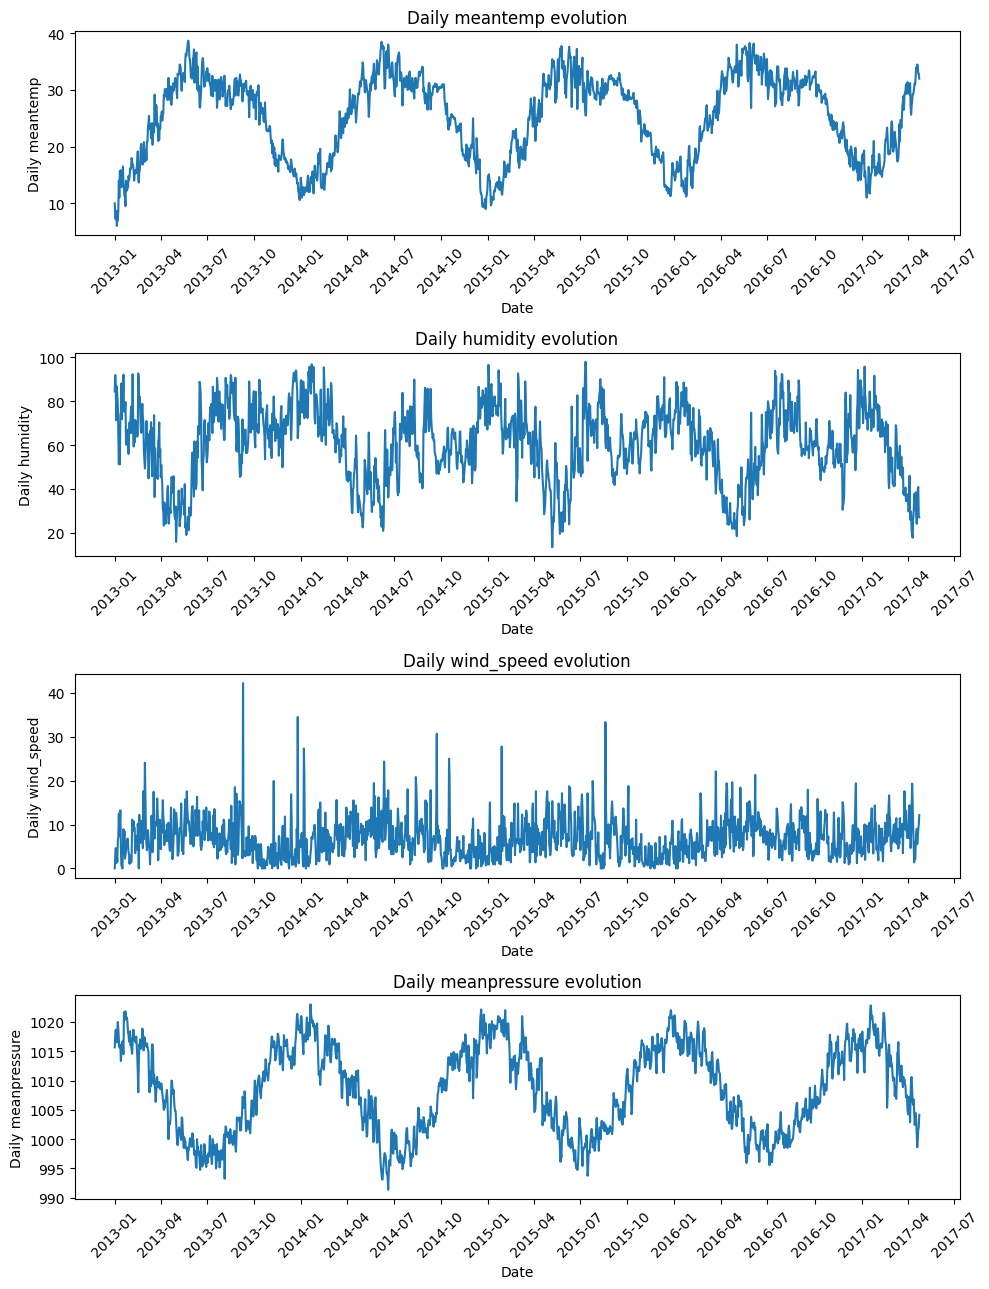

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 13))
for i in range(len(numerical)):
    axes[i].plot(dataset['date'], dataset[numerical[i]], label= str(numerical[i]) + ' evolution')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Daily ' + str(numerical[i]))
    axes[i].set_title('Daily ' + str(numerical[i]) + ' evolution')
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[i].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

#### Comparing temperature and pressure

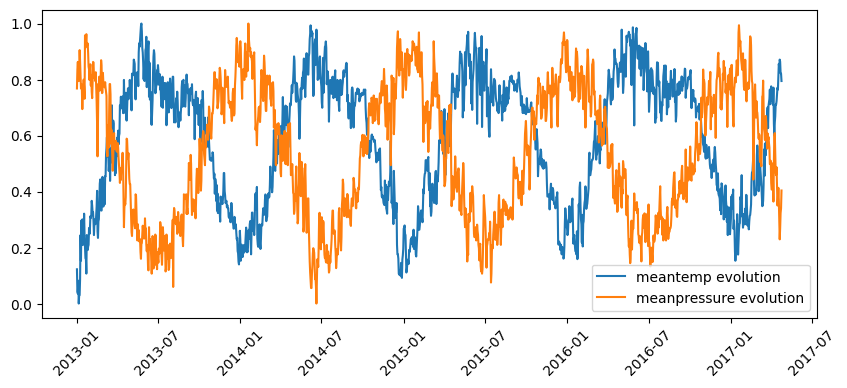

In [ ]:
columns_to_normalize = ['meantemp', 'meanpressure']
plt.figure(figsize=(10, 4))

df_norm = (dataset[columns_to_normalize] - dataset[columns_to_normalize].min()) / (dataset[columns_to_normalize].max() - dataset[columns_to_normalize].min())
df_norm['date'] = dataset['date']
for col in columns_to_normalize:
  plt.plot(df_norm['date'], df_norm[col], label= str(col) + ' evolution')
  plt.tick_params(axis='x', rotation=45)

plt.legend()
plt.show()


### Comparing Years

In [ ]:
df_years = dataset.copy()
df_years['year'] = df_years['date'].dt.year
df_years['date'] = df_years['date'].dt.strftime('%d-%m')

In [ ]:
df_years = df_years[df_years['date'] != '29-02']

### Plots with 7 day rolling window average

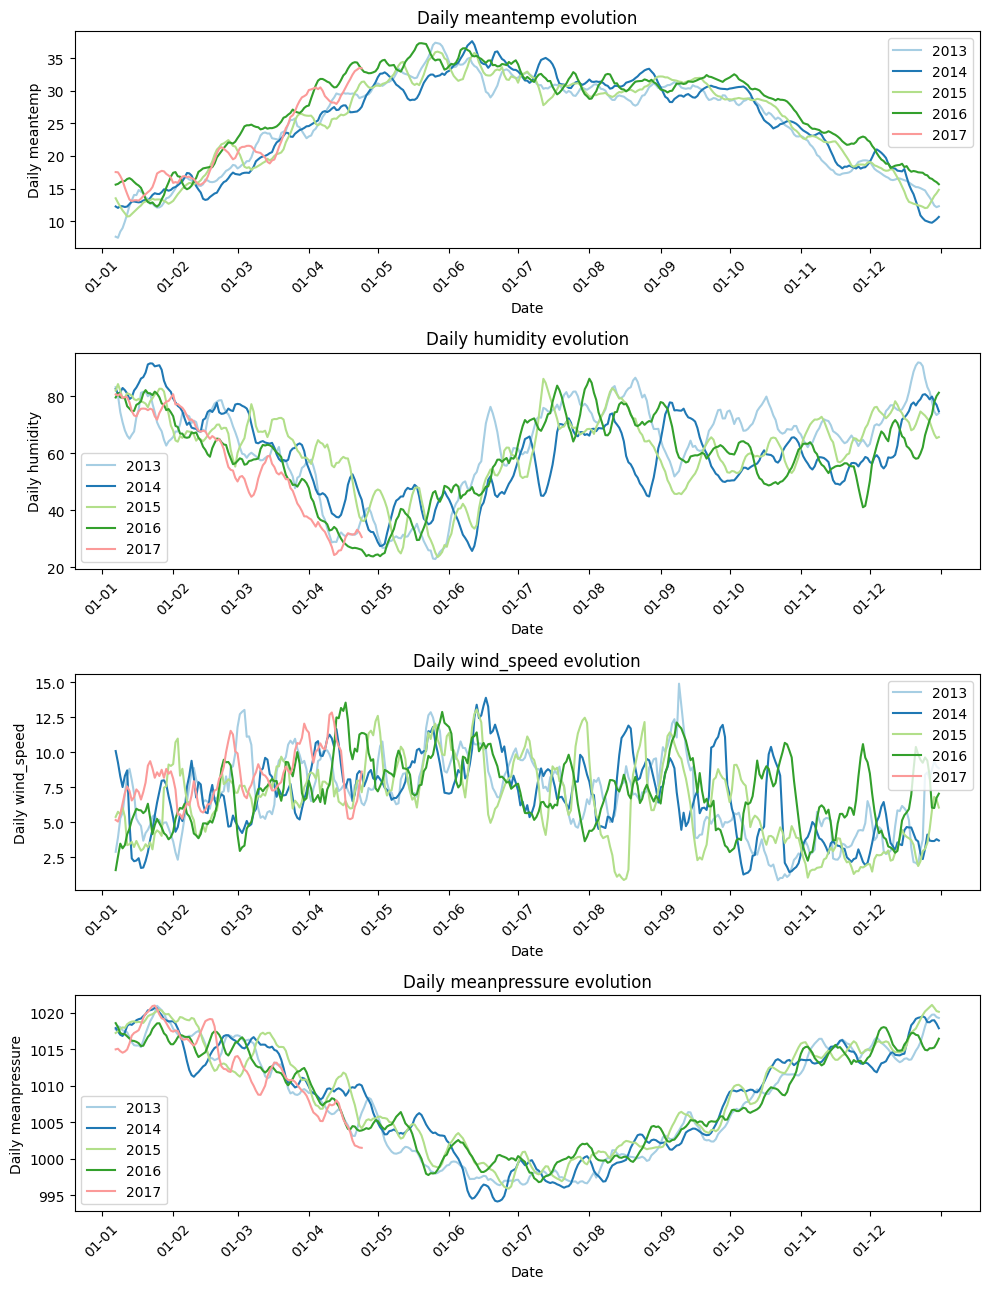

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 13))
cmap = plt.get_cmap('Paired')
window_size = 7 # adjust window size as needed

for i in range(len(numerical)):
    for j, year in enumerate(np.unique(df_years['year'].values)):
        data = df_years.loc[df_years['year'] == year, numerical[i]]
        smoothed_data = data.rolling(window_size).mean()
        axes[i].plot(df_years.loc[df_years['year'] == year, 'date'], smoothed_data, label= str(year), color=cmap(j))
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Daily ' + str(numerical[i]))
        axes[i].set_title('Daily ' + str(numerical[i]) + ' evolution')
        axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend()
    
plt.tight_layout()
plt.show()

Daily Plots

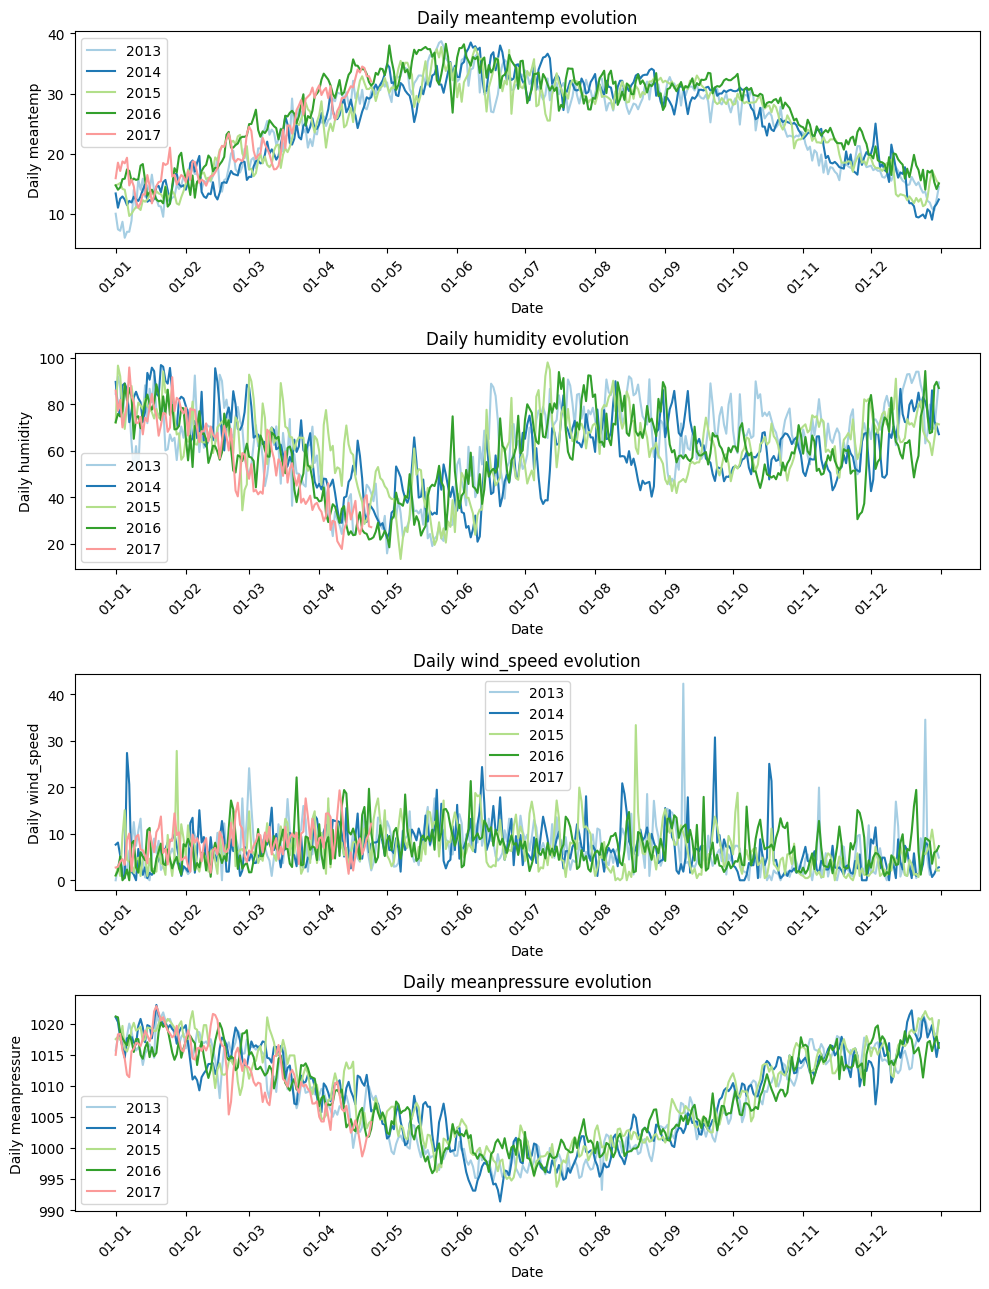

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 13))
cmap = plt.get_cmap('Paired')

for i in range(len(numerical)):
    for j, year in enumerate(np.unique(df_years['year'].values)):
        axes[i].plot(df_years.loc[df_years['year'] == year, 'date'], df_years.loc[df_years['year'] == year, 
                     numerical[i]], label= str(year), color=cmap(j))
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Daily ' + str(numerical[i]))
        axes[i].set_title('Daily ' + str(numerical[i]) + ' evolution')
        axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend()
    
plt.tight_layout()
plt.show()

## Correlation Matrix

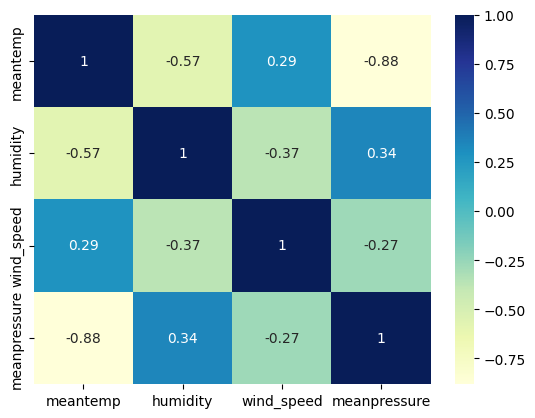

In [ ]:
# Compute the correlation matrix
corr = dataset[numerical].corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap="YlGnBu")

# Show the plot
plt.show()

- Scatter plots 
- Cross correlation analysis (?)

### Cross correlation analysis

[]

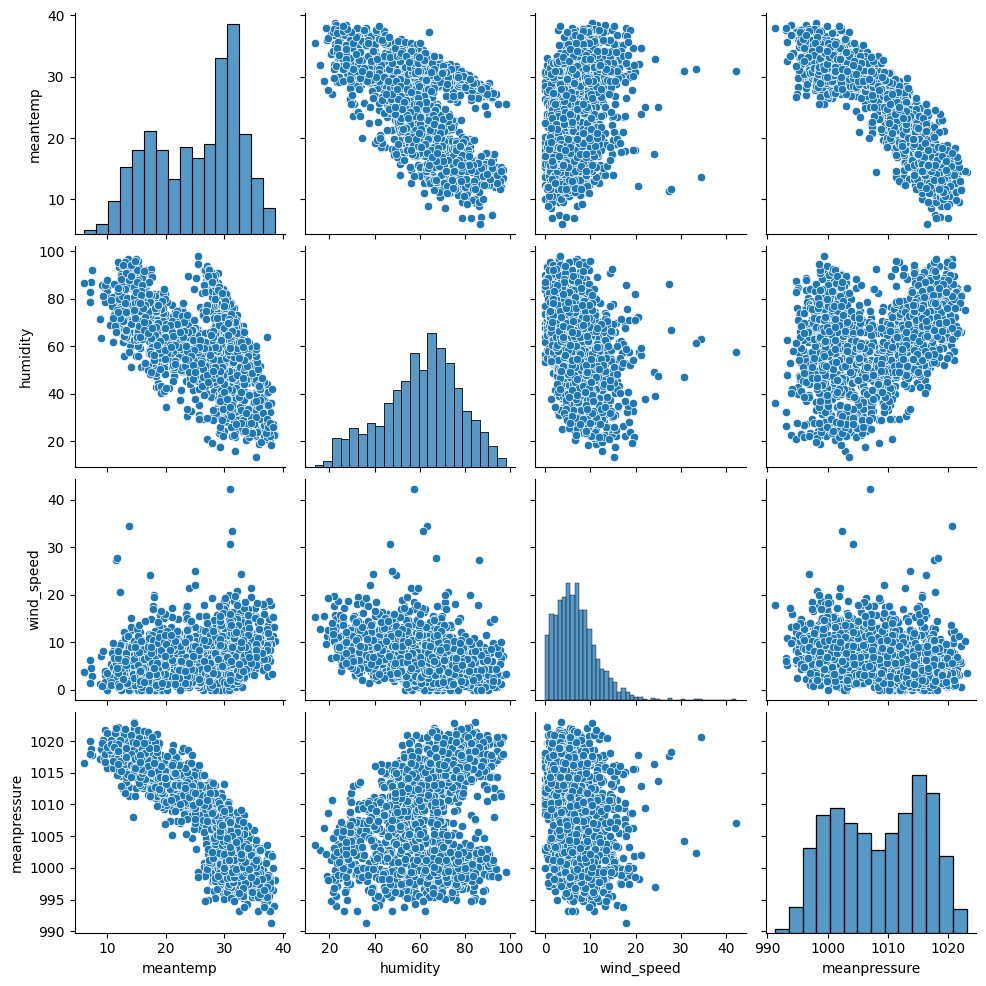

In [ ]:
sns.pairplot(data=dataset[numerical])
plt.plot()

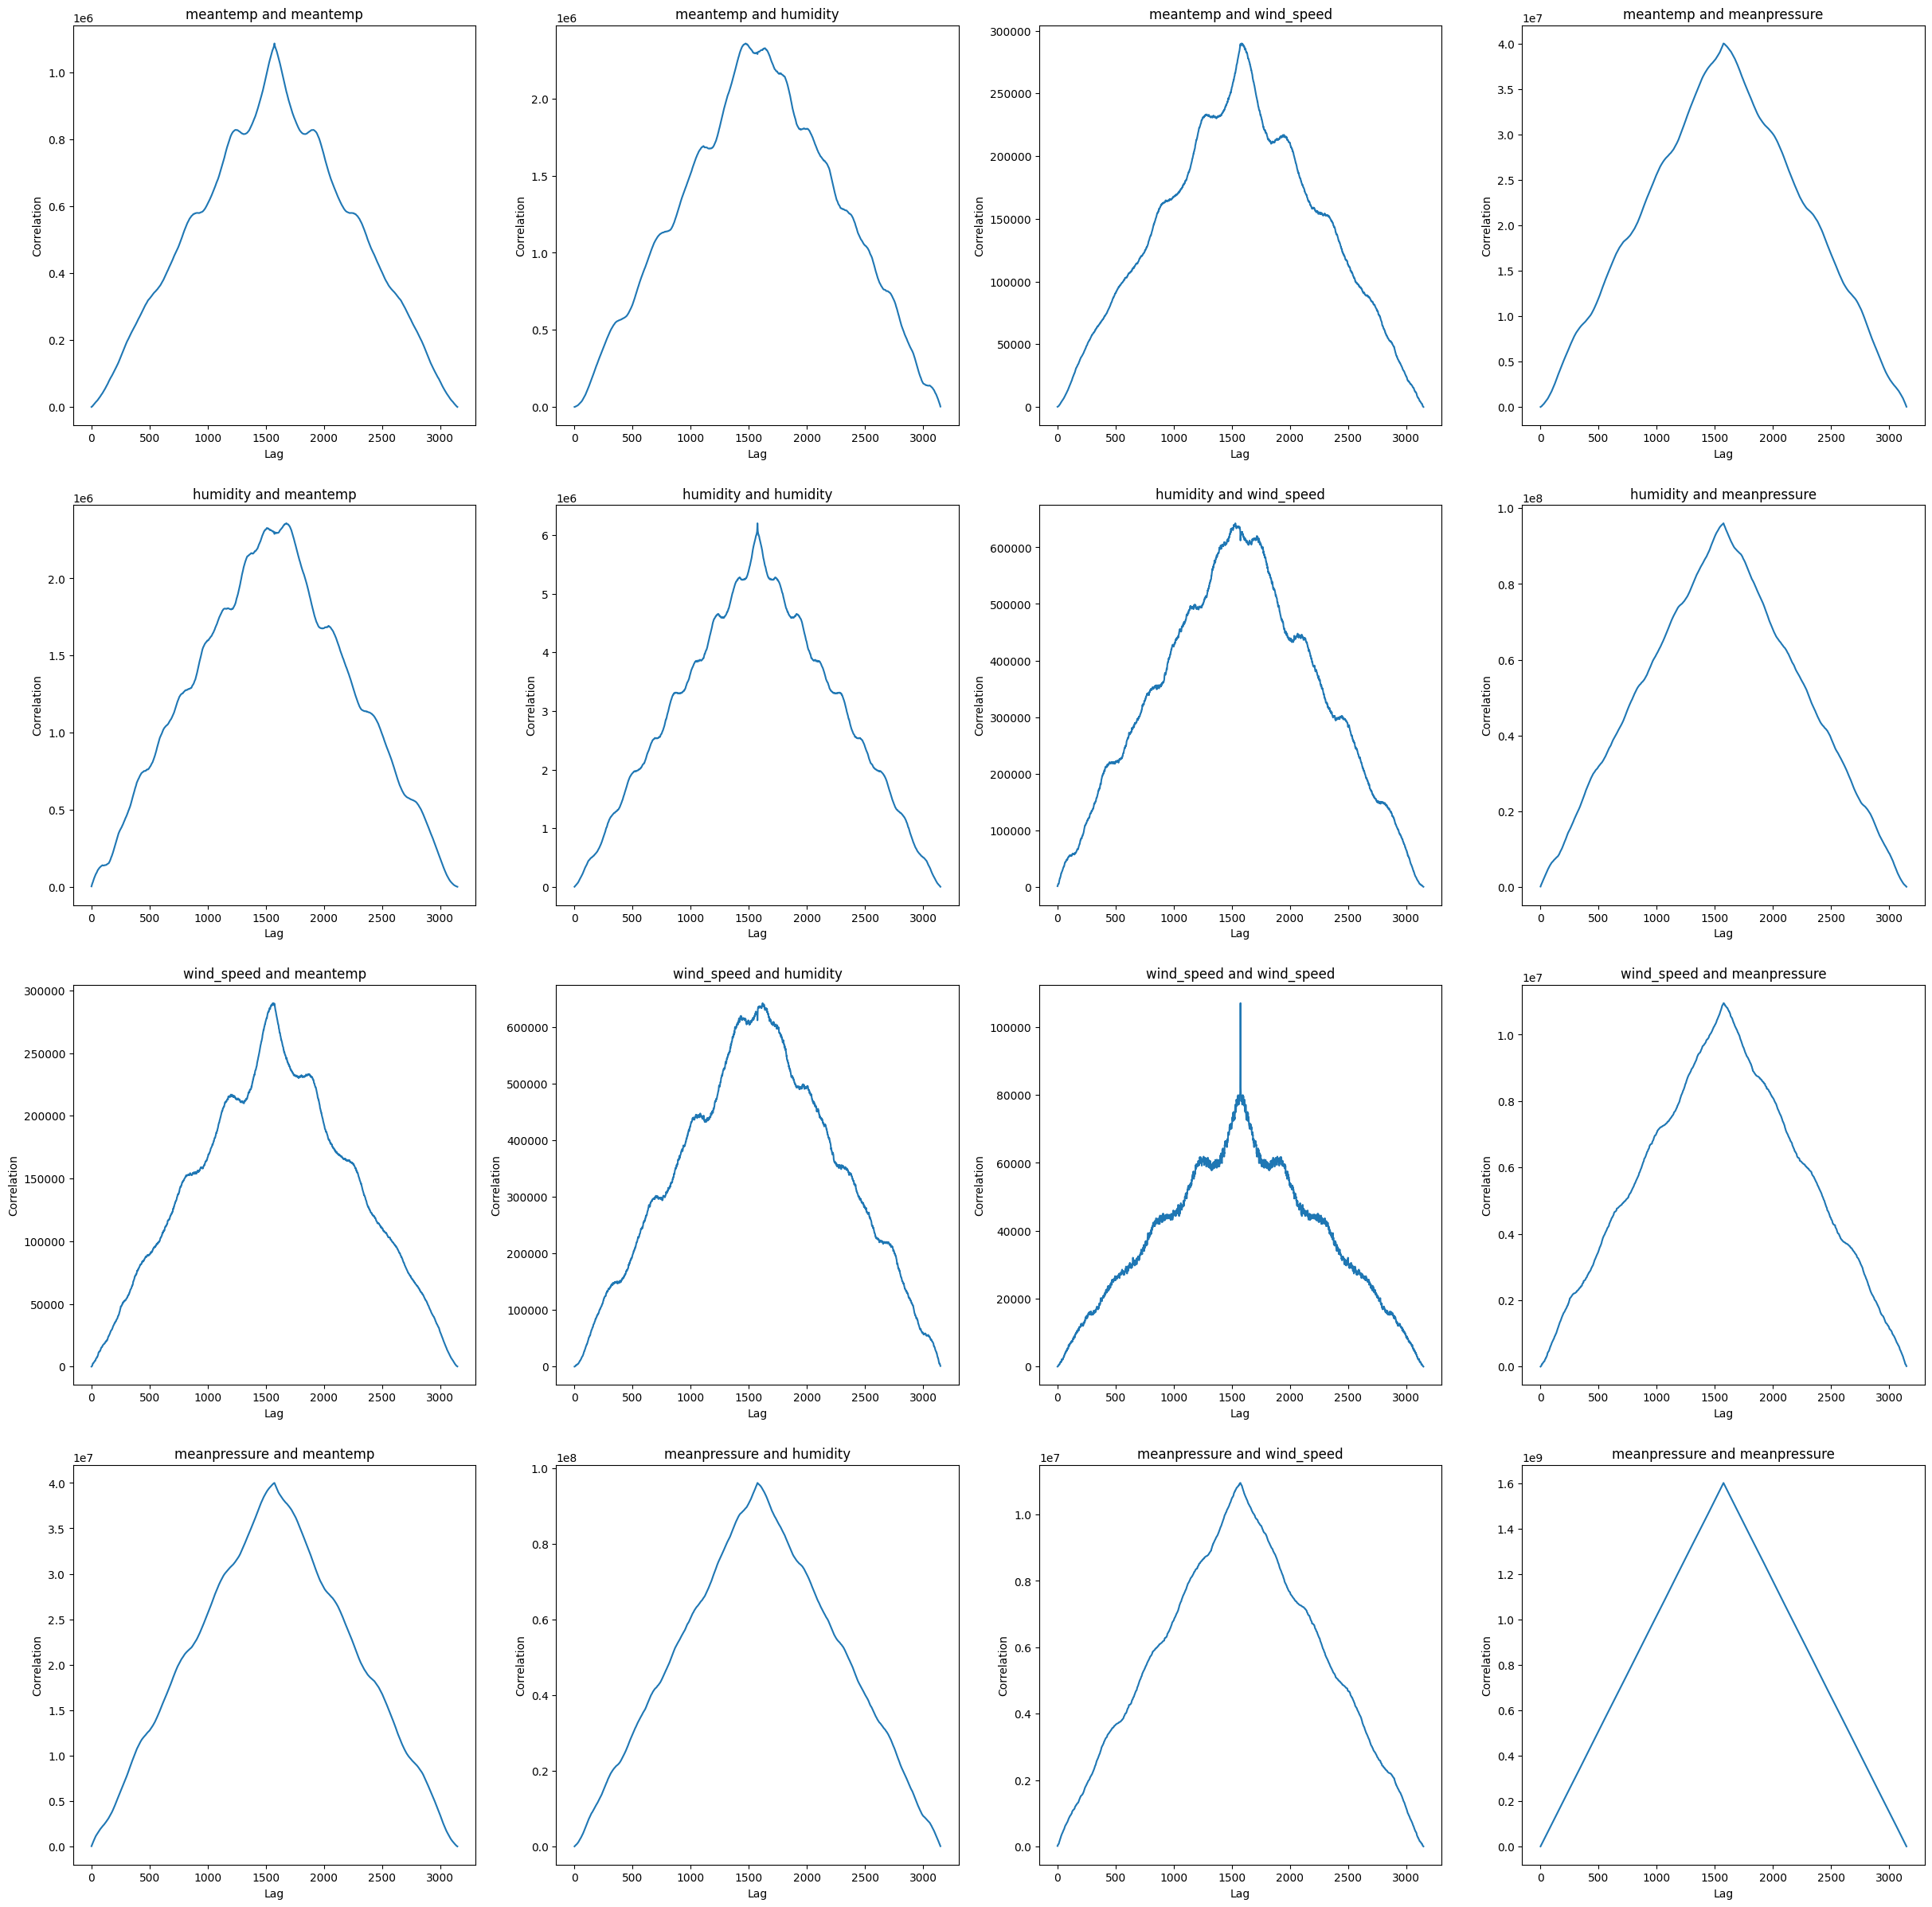

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(30,30))

# Loop through each pair of columns
for i in range(len(numerical)):
    for j in range(len(numerical)):

      # calculate cross-correlation using numpy.correlate
      corr = np.correlate(dataset[numerical[i]], dataset[numerical[j]], mode='full')
      axs[i, j].plot(corr)
        
      # Add labels to the plot
      axs[i, j].set_xlabel('Lag')
      axs[i, j].set_ylabel('Correlation')
      axs[i, j].set_title(f'{numerical[i]} and {numerical[j]}')

plt.show()

## Splitting Dataset

In [ ]:
# split the data into train, validation, and test sets
train_size = 0.7
val_size = 0.15
test_size = 0.15

train_end_index = int(train_size * len(dataset))
val_end_index = int((train_size + val_size) * len(dataset))

train_df = dataset.iloc[:train_end_index]
val_df = dataset.iloc[train_end_index:val_end_index]
test_df = dataset.iloc[val_end_index:]

<a id="modelling"></a>
#Modelling

<a id="ar"></a>
### AR

In [ ]:
# check the stationarity and order of the AR model.
# In case the p-value is less than 0.05, the time series data can be considered stationary
result = sm.tsa.stattools.adfuller(train_df['meantemp'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
# p-value > 0.05 therefore we reject the null hypothesis that it has stationarity


# We applY differencing to make the data stationary (WHY?)
diff_series_train = train_df['meantemp'].diff().dropna()
diff_series_val = val_df['meantemp'].diff().dropna()
diff_series_test = test_df['meantemp'].diff().dropna()

# Determine the order of the AR model by using the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC)
model = sm.tsa.arma_order_select_ic(diff_series_train, ic=['aic', 'bic'])
print('AIC', model.aic_min_order)
print('BIC', model.bic_min_order)


ADF Statistic: -2.0465267102319835
p-value: 0.2665524603661301
Critical Values: {'1%': -3.4363635475753824, '5%': -2.864195245967465, '10%': -2.5681837404258903}
AIC (1, 1)
BIC (1, 1)


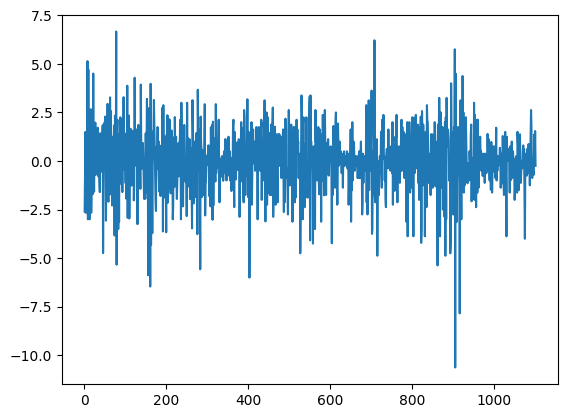

In [ ]:
diff_series_train.plot()
plt.show()

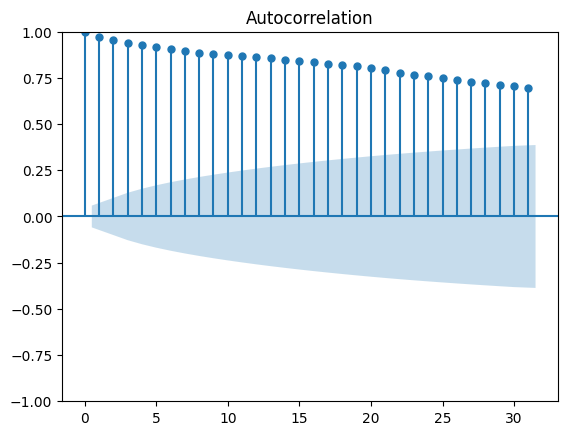

In [ ]:
# Partial autocorrelation plot
plot_acf(train_df['meantemp'])
plt.show()

<Axes: >

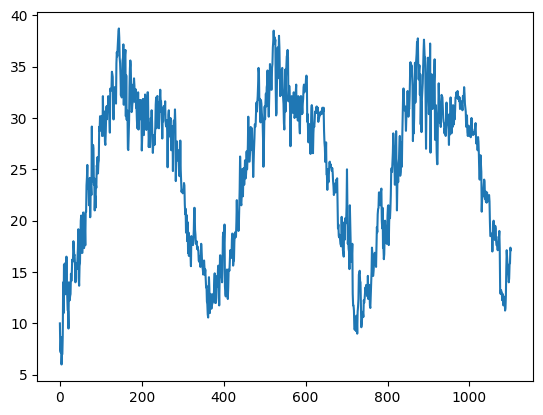

In [ ]:
train_df['meantemp'].plot()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


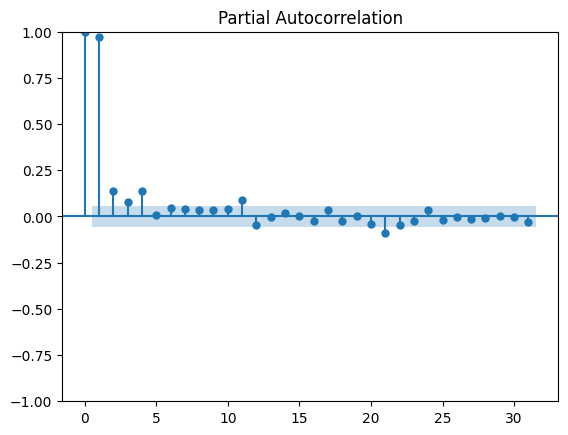

In [ ]:
# Partial autocorrelation plot
plot_pacf(train_df['meantemp'])
plt.show()

### Weekly Predictions

In [ ]:
def weeklyAR(lag_order=1):
  # prepare the data
  history = [x for x in diff_series_train]
  predictions = list()
  val = list(diff_series_val)

  # create the AutoReg model with the training data
  model = AutoReg(diff_series_train, lags=lag_order)

  # start the Walk-Forward process
  for t in range(0, len(val), 7):

      # create an AutoReg model with the historical data
      # turn off differencing for the ARIMA model
      model = AutoReg(history, lags=lag_order)

      # train the model
      model_fit = model.fit()

      # make a forecast for the next week
      week_forecast = model_fit.predict(start=len(history), end=len(history)+6)

      # loop through each day in the forecasted week
      for days in range(t, t+7):

          # if we are still in the validation data range
          if days < len(val):
              
              # get the predicted value for the current day
              predicted_value = week_forecast[days-t]

              # add the predicted value to the list of predictions
              predictions.append(predicted_value)

              # get the actual value for the current day
              actual_value = val[days]

              # add the actual value to the historical data for the next iteration
              history.append(actual_value)

    
  val_df2 = diff_series_val.reset_index().drop(columns='index')
  # Plotting results
  plt.plot(predictions, color='orange') # prediction
  plt.plot(val_df2)   # data we are trying to predict
  plt.show()

  mse = mean_squared_error(val_df2, predictions)
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

Weekly AR model with lag order 1


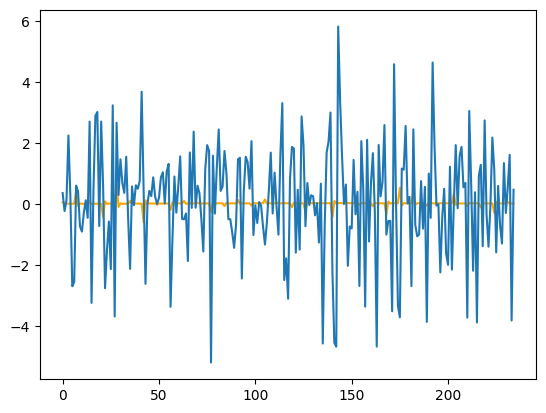

Mean Squared Error: 3.29
Root Mean Squared Error: 1.81


Weekly AR model with lag order 3


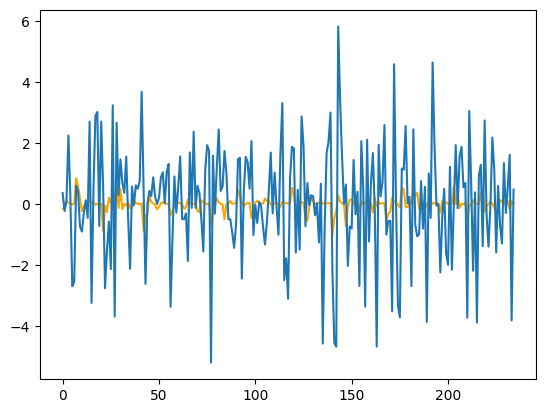

Mean Squared Error: 3.18
Root Mean Squared Error: 1.78


Weekly AR model with lag order 7


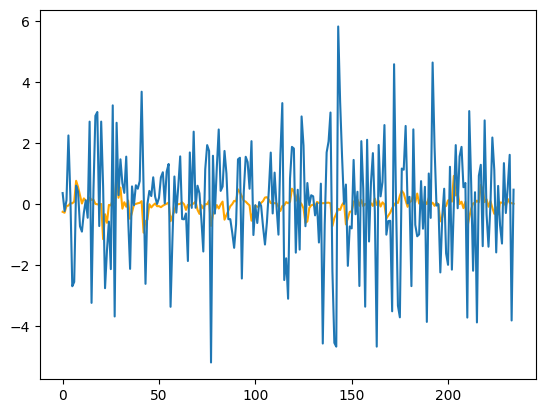

Mean Squared Error: 3.20
Root Mean Squared Error: 1.79


Weekly AR model with lag order 15


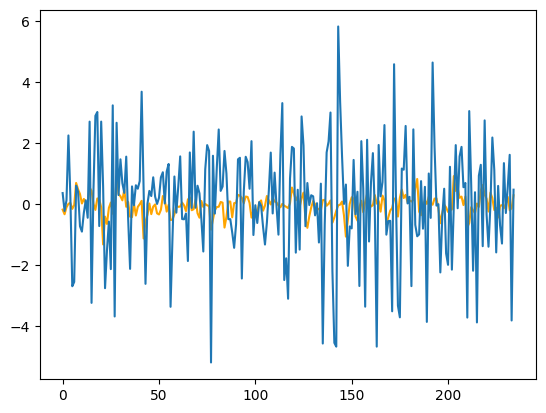

Mean Squared Error: 3.16
Root Mean Squared Error: 1.78


Weekly AR model with lag order 30


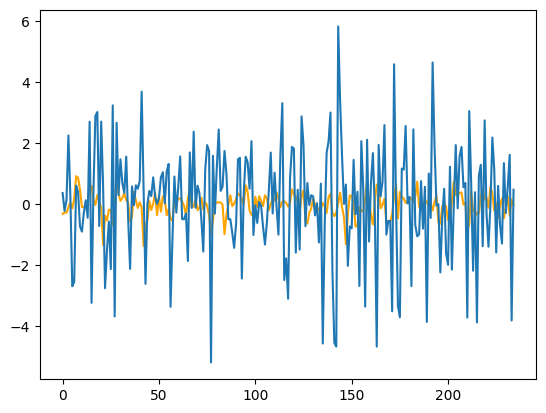

Mean Squared Error: 3.23
Root Mean Squared Error: 1.80


Weekly AR model with lag order 60


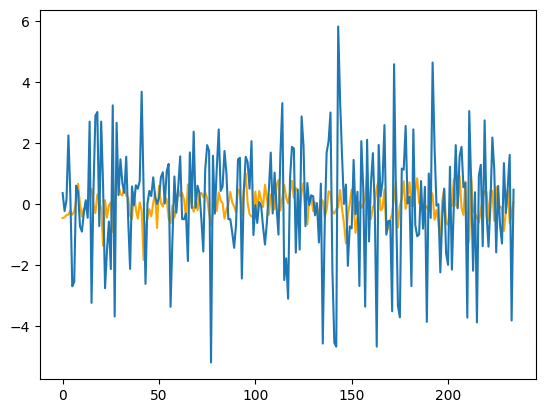

Mean Squared Error: 3.24
Root Mean Squared Error: 1.80




In [ ]:
import warnings
warnings.filterwarnings('ignore')

lag_orders = [1, 3, 7, 15, 30, 60]

for lag in lag_orders:
  print('Weekly AR model with lag order', lag)
  weeklyAR(lag)
  print()
  print()

### Daily predictions

In [ ]:
def dailyAR(lag_order=1):
  # prepare the data
  history = [x for x in diff_series_train]
  predictions = list()
  val = list(diff_series_val)

  # create the AutoReg model with the training data
  model = AutoReg(history, lags=lag_order)

  # start the Walk-Forward process
  for t in range(len(val)):

      # create an AutoReg model with the historical data
      # turn off differencing for the ARIMA model
      model = AutoReg(history, lags=lag_order)

      # train the model
      model_fit = model.fit()

      # make a forecast for the next week
      predicted_value = model_fit.predict(start=len(history), end=len(history)+1)[0]

      # add the predicted value to the list of predictions
      predictions.append(predicted_value)

      # get the actual value for the current day
      actual_value = val[t]

      # add the actual value to the historical data for the next iteration
      history.append(actual_value)

  val_df2 = diff_series_val.reset_index().drop(columns='index')
  # Plotting results
  plt.plot(predictions, color='orange') # prediction
  plt.plot(val_df2)   # data we are trying to predict
  plt.show()

  mse = mean_squared_error(val_df2, predictions)
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

Daily AR model with lag order 1


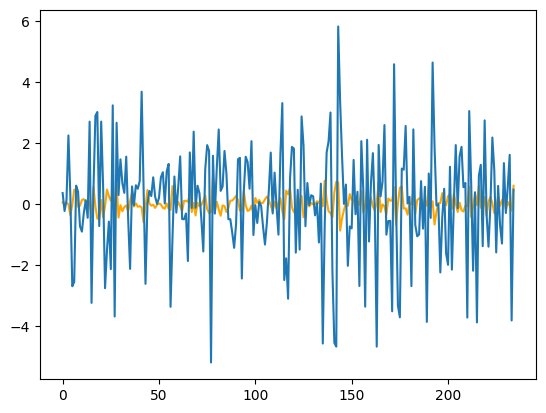

Mean Squared Error: 3.32
Root Mean Squared Error: 1.82


Daily AR model with lag order 3


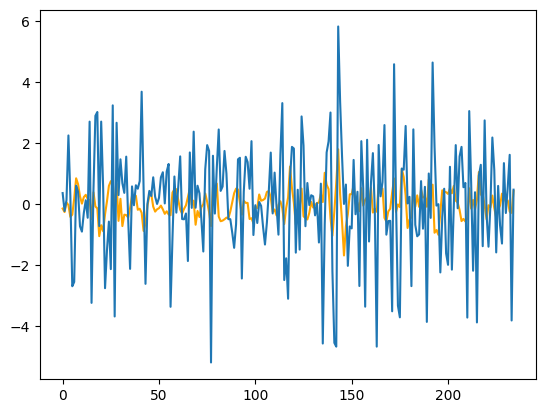

Mean Squared Error: 3.16
Root Mean Squared Error: 1.78


Daily AR model with lag order 7


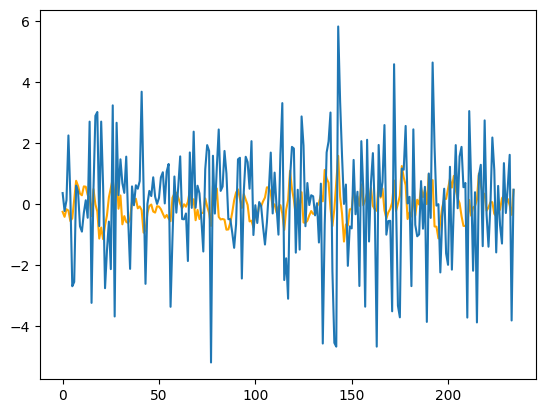

Mean Squared Error: 3.09
Root Mean Squared Error: 1.76


Daily AR model with lag order 15


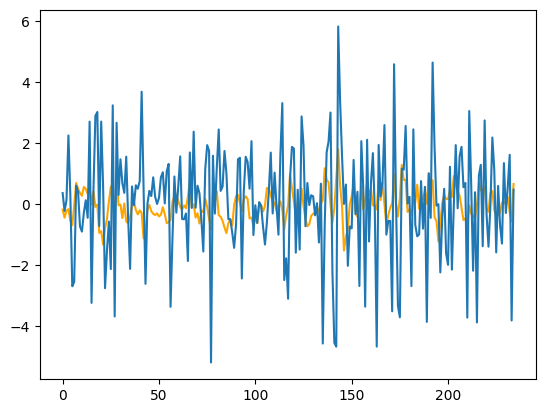

Mean Squared Error: 3.01
Root Mean Squared Error: 1.74


Daily AR model with lag order 30


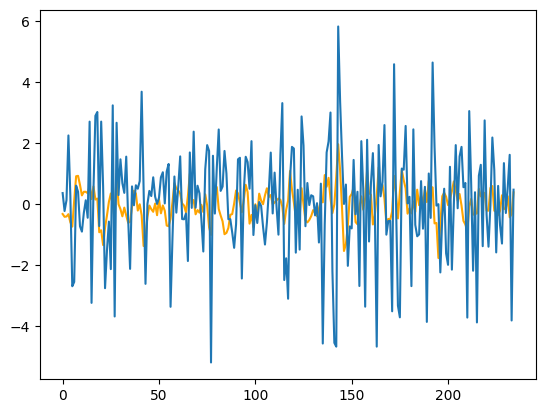

Mean Squared Error: 3.06
Root Mean Squared Error: 1.75


Daily AR model with lag order 60


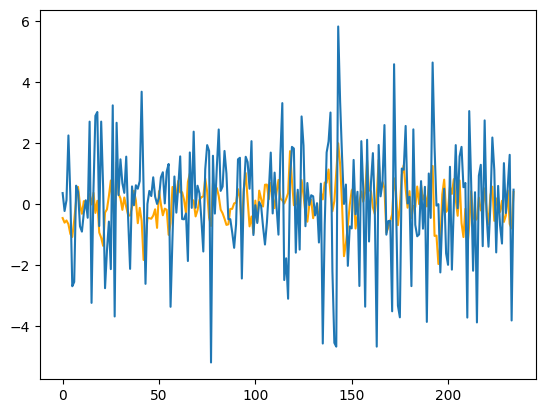

Mean Squared Error: 3.05
Root Mean Squared Error: 1.75




In [ ]:
import warnings
warnings.filterwarnings('ignore')

lag_orders = [1, 3, 7, 15, 30, 60]

for lag in lag_orders:
  print('Daily AR model with lag order', lag)
  dailyAR(lag)
  print()
  print()

https://www.section.io/engineering-education/univariate-time-series-analysis-with-arima-in-python/

<a id="sarima"></a>
### SARIMA

#### Weekly model fitting

In [ ]:
def weeklySARIMA(lag_order=1, season_duration=1):

  # create a list of historical temperature values
  history = [x for x in train_df['meantemp']]

  # create a list to store the predicted values
  predictions = []

  # create a list of validation temperature values
  val = list(val_df['meantemp'])

  # start the walk-forward validation process
  for t in range(0, len(val), 7):

      # create a SARIMA model with the historical data
      # turn off differencing for the ARIMA model
      model = sm.tsa.statespace.SARIMAX(history, order=(lag_order,1,1), seasonal_order=(1,1,1,season_duration))
      
      # fit the SARIMA model
      model_fit = model.fit(trend='nc', disp=0)

      # make a 7-day forecast using the fitted SARIMA model
      week_forecast = model_fit.forecast(steps=7)

      # iterate over the next 7 days in the validation set
      for days in range(t, t+7):
        if days < len(val):
          # get the predicted temperature value for the current day
          predicted_value = week_forecast[days-t]

          # add the predicted value to the list of predictions
          predictions.append(predicted_value)
              
          # get the actual temperature value for the current day
          actual_value = val[days]
      
          # add the actual value to the historical data
          history.append(actual_value)
  
  val_df2 = val_df.reset_index().drop(columns='index')
  # Plotting results
  plt.plot(predictions, color='orange') # prediction
  plt.plot(val_df2['meantemp'])   # data we are trying to predict
  plt.show()

  mse = mean_squared_error(val_df2['meantemp'], predictions)
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

Weekly SARIMA model with lag order 1 and season duration 15


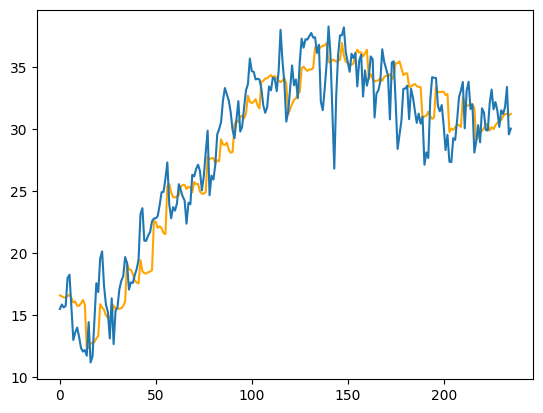

Mean Squared Error: 5.32
Root Mean Squared Error: 2.31


Weekly SARIMA model with lag order 1 and season duration 30


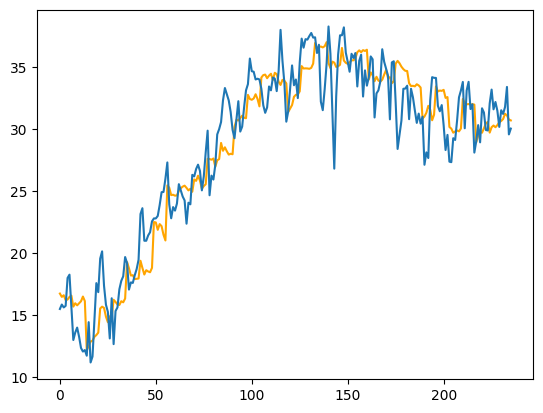

Mean Squared Error: 5.38
Root Mean Squared Error: 2.32


Weekly SARIMA model with lag order 7 and season duration 15


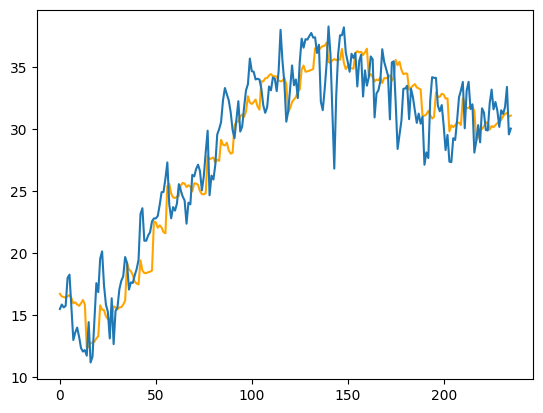

Mean Squared Error: 5.32
Root Mean Squared Error: 2.31


Weekly SARIMA model with lag order 7 and season duration 30


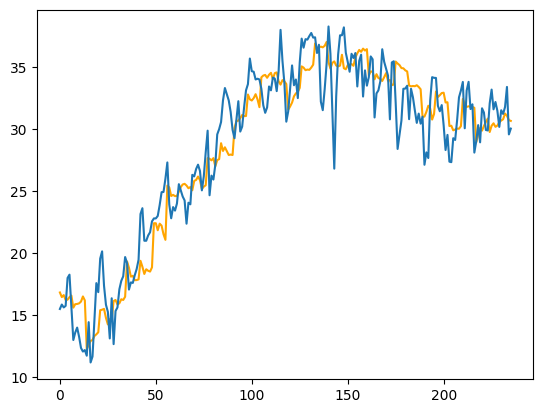

Mean Squared Error: 5.35
Root Mean Squared Error: 2.31




In [ ]:
import warnings
warnings.filterwarnings('ignore')

lag_orders = [1, 7]
season_duration = [15, 30]

for lag in lag_orders:
  for season in season_duration:
    print(f'Weekly SARIMA model with lag order {lag} and season duration {season}')
    weeklySARIMA(lag_order=lag, season_duration=season)
    print()
    print()

#### Daily model fitting

In [ ]:
def dailySARIMA(lag_order=1, season_duration=1):

  history = [x for x in train_df['meantemp']]
  predictions = list()
  val = list(val_df['meantemp'])

  # start the walk-forward validation process
  for t in range(0, len(val)):

    # create a SARIMA model with the historical data
    # turn off differencing for the ARIMA model
    model = sm.tsa.statespace.SARIMAX(history, order=(lag_order,0,1), seasonal_order=(1,1,1,season_duration))
    
    # fit the SARIMA model
    model_fit = model.fit(trend='nc', disp=0)

    # make forecast using the fitted SARIMA model
    predicted_value = model_fit.forecast()[0]

    # add the predicted value to the list of predictions
    predictions.append(predicted_value)
        
    # get the actual temperature value for the current day
    actual_value = val[t]

    # add the actual value to the historical data
    history.append(actual_value)

    if t % 30 == 0:
      print(t)
    
  val_df2 = val_df.reset_index().drop(columns='index')
  # Plotting results
  plt.plot(predictions, color='orange') # prediction
  plt.plot(val_df2['meantemp'])   # data we are trying to predict
  plt.show()

  mse = mean_squared_error(val_df2['meantemp'], predictions)
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

Daily SARIMA model with lag order 1 and season duration 15
0
30
60
90
120
150
180
210


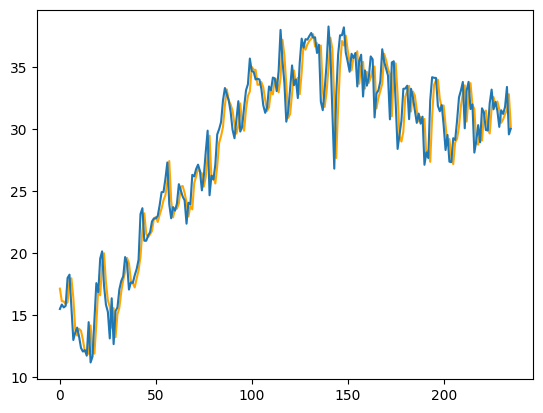

Mean Squared Error: 3.37
Root Mean Squared Error: 1.84


Daily SARIMA model with lag order 1 and season duration 30
0
30
60
90
120
150
180
210


In [ ]:
import warnings
warnings.filterwarnings('ignore')

lag_orders = [1, 7]
season_duration = [15, 30]

for lag in lag_orders:
  for season in season_duration:
    print(f'Daily SARIMA model with lag order {lag} and season duration {season}')
    dailySARIMA(lag_order=lag, season_duration=season)
    print()
    print()

<a id="ann"></a>
### ANN

In [ ]:
# Sliding Windows Method
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

df_temp = pd.DataFrame(dataset['meantemp']).values
df_temp = df_temp.astype('float32')


# split into train and test sets
train_size = int(len(df_temp) * 0.7)
val_size = int(len(df_temp) * 0.15)
test_size = len(df_temp) - train_size - val_size

train, val, test = df_temp[0:train_size], df_temp[train_size:train_size+val_size], df_temp[train_size+val_size:len(df_temp)] 
# train, val, test = df_temp[0:train_size,:], df_temp[train_size:train_size+val_size,:], df_temp[train_size+val_size:len(df_temp),:] 

In [ ]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)


look_back = 3
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)

#### Model 1

Epoch 1/25
549/549 - 1s - loss: 552.0264 - 785ms/epoch - 1ms/step
Epoch 2/25
549/549 - 0s - loss: 5.4613 - 484ms/epoch - 881us/step
Epoch 3/25
549/549 - 1s - loss: 5.0555 - 628ms/epoch - 1ms/step
Epoch 4/25
549/549 - 1s - loss: 5.0248 - 633ms/epoch - 1ms/step
Epoch 5/25
549/549 - 1s - loss: 4.9342 - 577ms/epoch - 1ms/step
Epoch 6/25
549/549 - 1s - loss: 4.8477 - 890ms/epoch - 2ms/step
Epoch 7/25
549/549 - 1s - loss: 4.7671 - 704ms/epoch - 1ms/step
Epoch 8/25
549/549 - 1s - loss: 4.2216 - 683ms/epoch - 1ms/step
Epoch 9/25
549/549 - 1s - loss: 3.8984 - 702ms/epoch - 1ms/step
Epoch 10/25
549/549 - 1s - loss: 3.6444 - 683ms/epoch - 1ms/step
Epoch 11/25
549/549 - 1s - loss: 3.4524 - 648ms/epoch - 1ms/step
Epoch 12/25
549/549 - 1s - loss: 3.3066 - 652ms/epoch - 1ms/step
Epoch 13/25
549/549 - 0s - loss: 3.2600 - 485ms/epoch - 883us/step
Epoch 14/25
549/549 - 0s - loss: 3.0701 - 443ms/epoch - 806us/step
Epoch 15/25
549/549 - 1s - loss: 3.0464 - 501ms/epoch - 913us/step
Epoch 16/25
549/549 - 1s

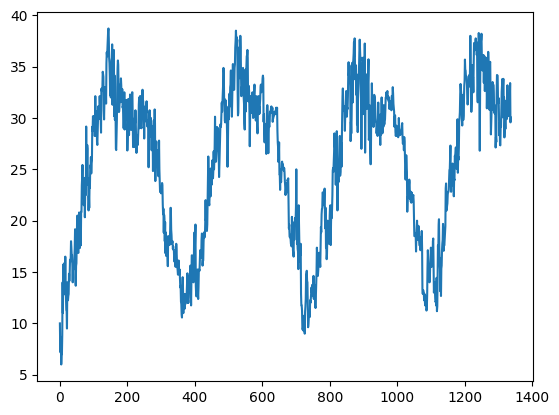

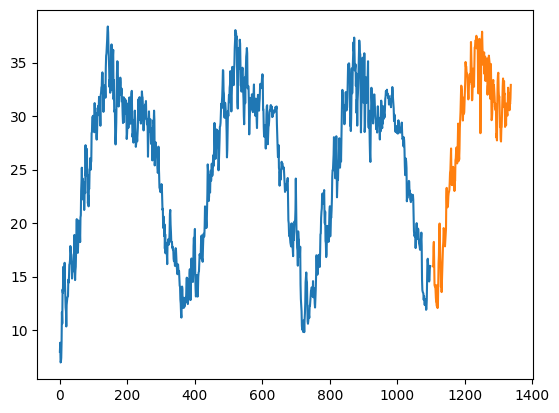

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=2, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
valScore = model.evaluate(valX, valY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (valScore, math.sqrt(valScore)))


# generate predictions for training
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)


# shift test predictions for plotting
valPredictPlot = np.empty_like(np.concatenate((train, val), axis=0))
valPredictPlot[:, :] = np.nan
valPredictPlot[len(trainPredict)+(look_back*2)+1:len(np.concatenate((train, val), axis=0))-1, :] = valPredict


# plot baseline and predictions
plt.plot(np.concatenate((train, val), axis=0))
plt.show()
plt.plot(trainPredict)
plt.plot(valPredictPlot)
plt.show()

In [ ]:
np.concatenate((train_df, val_df), axis=0)

### Model 2

Epoch 1/25
549/549 - 1s - loss: 10.2463 - 1s/epoch - 2ms/step
Epoch 2/25
549/549 - 1s - loss: 3.2272 - 539ms/epoch - 982us/step
Epoch 3/25
549/549 - 1s - loss: 3.1102 - 517ms/epoch - 942us/step
Epoch 4/25
549/549 - 1s - loss: 3.3760 - 542ms/epoch - 988us/step
Epoch 5/25
549/549 - 1s - loss: 3.0842 - 540ms/epoch - 983us/step
Epoch 6/25
549/549 - 1s - loss: 3.1711 - 713ms/epoch - 1ms/step
Epoch 7/25
549/549 - 1s - loss: 3.2627 - 693ms/epoch - 1ms/step
Epoch 8/25
549/549 - 1s - loss: 3.3679 - 697ms/epoch - 1ms/step
Epoch 9/25
549/549 - 1s - loss: 3.0926 - 648ms/epoch - 1ms/step
Epoch 10/25
549/549 - 1s - loss: 3.2416 - 532ms/epoch - 970us/step
Epoch 11/25
549/549 - 1s - loss: 3.1874 - 547ms/epoch - 997us/step
Epoch 12/25
549/549 - 1s - loss: 3.3489 - 564ms/epoch - 1ms/step
Epoch 13/25
549/549 - 1s - loss: 2.9767 - 523ms/epoch - 952us/step
Epoch 14/25
549/549 - 1s - loss: 3.1422 - 697ms/epoch - 1ms/step
Epoch 15/25
549/549 - 1s - loss: 3.0246 - 989ms/epoch - 2ms/step
Epoch 16/25
549/549 - 

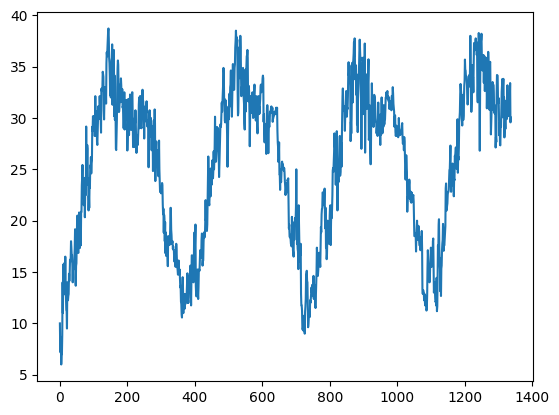

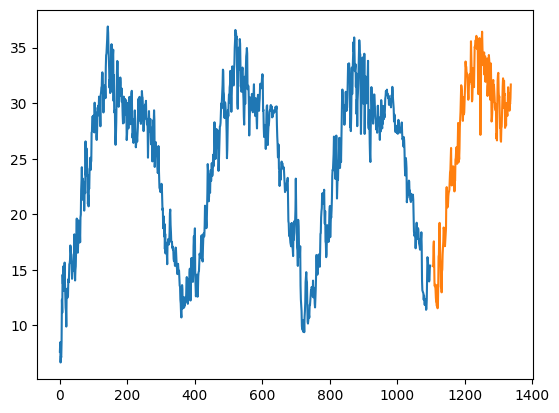

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(64, input_dim=look_back, activation='relu'))
model.add(Dense(16, input_dim=look_back, activation='relu'))
model.add(Dense(4, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=2, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
valScore = model.evaluate(valX, valY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (valScore, math.sqrt(valScore)))


# generate predictions for training
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)


# shift test predictions for plotting
valPredictPlot = np.empty_like(np.concatenate((train, val), axis=0))
valPredictPlot[:, :] = np.nan
valPredictPlot[len(trainPredict)+(look_back*2)+1:len(np.concatenate((train, val), axis=0))-1, :] = valPredict


# plot baseline and predictions
plt.plot(np.concatenate((train, val), axis=0))
plt.show()
plt.plot(trainPredict)
plt.plot(valPredictPlot)
plt.show()

We have overcomplicated the model by adding more layers with too many neurons for the problem at hand.

### Model 1 GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# define the MLP model
def create_model(activation='relu', nodes=8):
    model = Sequential()
    model.add(Dense(nodes, input_dim=look_back, activation=activation))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# create KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [1, 2, 4, 8, 32]
nodes = [4, 8, 16]
epochs = [5, 10, 20]
activation = ['relu', 'sigmoid', 'selu']

param_grid = dict(batch_size=batch_size, nodes=nodes, epochs=epochs, activation=activation)

# perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(trainX, trainY)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


<ipython-input-34-cdba070b8d97>:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -2.706926 using {'activation': 'selu', 'batch_size': 1, 'epochs': 20, 'nodes': 8}


### Model 3

Epoch 1/20
1098/1098 - 5s - loss: 4.5685 - 5s/epoch - 4ms/step
Epoch 2/20
1098/1098 - 4s - loss: 3.9403 - 4s/epoch - 3ms/step
Epoch 3/20
1098/1098 - 2s - loss: 3.4654 - 2s/epoch - 1ms/step
Epoch 4/20
1098/1098 - 1s - loss: 3.4186 - 1s/epoch - 1ms/step
Epoch 5/20
1098/1098 - 1s - loss: 3.1284 - 1s/epoch - 1ms/step
Epoch 6/20
1098/1098 - 1s - loss: 3.1177 - 1s/epoch - 1ms/step
Epoch 7/20
1098/1098 - 1s - loss: 3.0943 - 1s/epoch - 1ms/step
Epoch 8/20
1098/1098 - 1s - loss: 3.1484 - 1s/epoch - 1ms/step
Epoch 9/20
1098/1098 - 2s - loss: 3.0001 - 2s/epoch - 2ms/step
Epoch 10/20
1098/1098 - 2s - loss: 3.0619 - 2s/epoch - 2ms/step
Epoch 11/20
1098/1098 - 1s - loss: 3.0467 - 1s/epoch - 1ms/step
Epoch 12/20
1098/1098 - 1s - loss: 3.1024 - 1s/epoch - 1ms/step
Epoch 13/20
1098/1098 - 1s - loss: 2.9351 - 1s/epoch - 1ms/step
Epoch 14/20
1098/1098 - 1s - loss: 3.0458 - 1s/epoch - 1ms/step
Epoch 15/20
1098/1098 - 1s - loss: 3.0078 - 1s/epoch - 1ms/step
Epoch 16/20
1098/1098 - 1s - loss: 2.9870 - 1s/ep

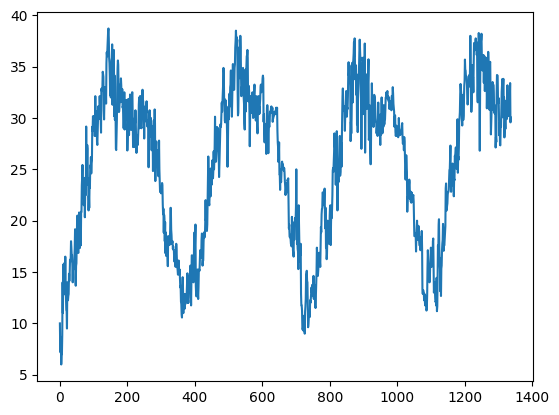

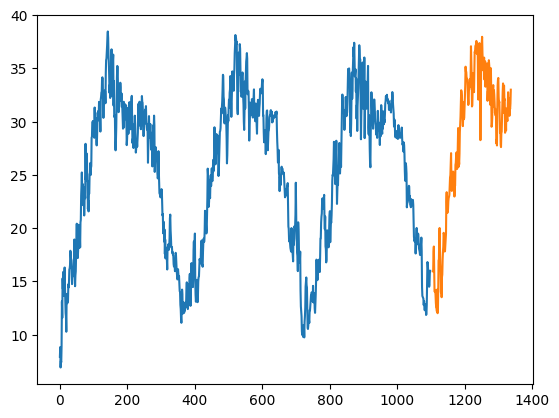

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='selu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
valScore = model.evaluate(valX, valY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (valScore, math.sqrt(valScore)))


# generate predictions for training
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)


# shift test predictions for plotting
valPredictPlot = np.empty_like(np.concatenate((train, val), axis=0))
valPredictPlot[:, :] = np.nan
valPredictPlot[len(trainPredict)+(look_back*2)+1:len(np.concatenate((train, val), axis=0))-1, :] = valPredict


# plot baseline and predictions
plt.plot(np.concatenate((train, val), axis=0))
plt.show()
plt.plot(trainPredict)
plt.plot(valPredictPlot)
plt.show()

### Increasing Window Size To 7

In [ ]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)


look_back = 7
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)

Epoch 1/20
1094/1094 - 3s - loss: 8.7652 - 3s/epoch - 3ms/step
Epoch 2/20
1094/1094 - 2s - loss: 3.4001 - 2s/epoch - 1ms/step
Epoch 3/20
1094/1094 - 1s - loss: 3.1437 - 1s/epoch - 1ms/step
Epoch 4/20
1094/1094 - 1s - loss: 3.0067 - 1s/epoch - 1ms/step
Epoch 5/20
1094/1094 - 1s - loss: 3.0239 - 1s/epoch - 1ms/step
Epoch 6/20
1094/1094 - 1s - loss: 2.9661 - 1s/epoch - 1ms/step
Epoch 7/20
1094/1094 - 1s - loss: 2.9159 - 1s/epoch - 1ms/step
Epoch 8/20
1094/1094 - 2s - loss: 3.0782 - 2s/epoch - 2ms/step
Epoch 9/20
1094/1094 - 2s - loss: 3.0658 - 2s/epoch - 2ms/step
Epoch 10/20
1094/1094 - 1s - loss: 2.9512 - 1s/epoch - 1ms/step
Epoch 11/20
1094/1094 - 1s - loss: 3.0076 - 1s/epoch - 1ms/step
Epoch 12/20
1094/1094 - 1s - loss: 2.8858 - 1s/epoch - 1ms/step
Epoch 13/20
1094/1094 - 1s - loss: 2.8963 - 1s/epoch - 1ms/step
Epoch 14/20
1094/1094 - 1s - loss: 2.9895 - 1s/epoch - 1ms/step
Epoch 15/20
1094/1094 - 1s - loss: 2.9204 - 1s/epoch - 1ms/step
Epoch 16/20
1094/1094 - 1s - loss: 2.9722 - 1s/ep

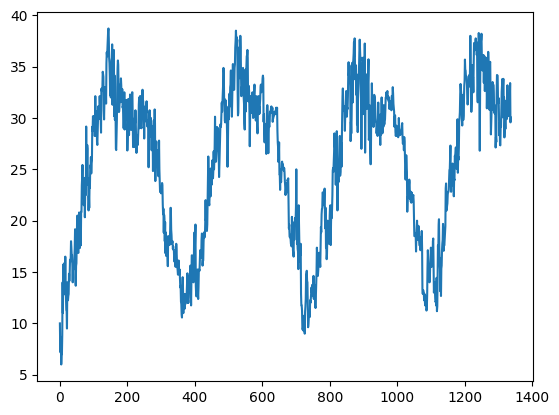

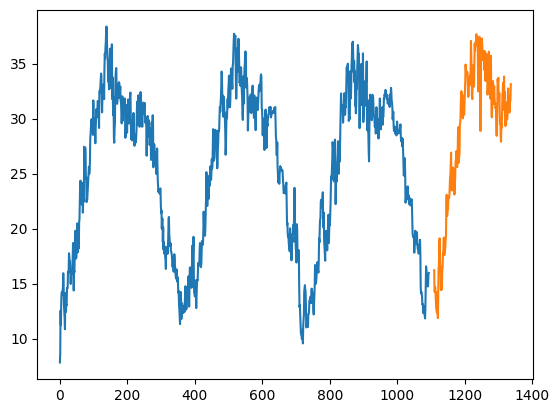

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='selu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
valScore = model.evaluate(valX, valY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (valScore, math.sqrt(valScore)))


# generate predictions for training
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)


# shift test predictions for plotting
valPredictPlot = np.empty_like(np.concatenate((train, val), axis=0))
valPredictPlot[:, :] = np.nan
valPredictPlot[len(trainPredict)+(look_back*2)+1:len(np.concatenate((train, val), axis=0))-1, :] = valPredict


# plot baseline and predictions
plt.plot(np.concatenate((train, val), axis=0))
plt.show()
plt.plot(trainPredict)
plt.plot(valPredictPlot)
plt.show()

### Lookback Window 5

In [ ]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)


look_back = 5
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)

Epoch 1/20
1096/1096 - 4s - loss: 144.7818 - 4s/epoch - 4ms/step
Epoch 2/20
1096/1096 - 2s - loss: 4.0550 - 2s/epoch - 2ms/step
Epoch 3/20
1096/1096 - 3s - loss: 3.8199 - 3s/epoch - 3ms/step
Epoch 4/20
1096/1096 - 2s - loss: 3.6666 - 2s/epoch - 2ms/step
Epoch 5/20
1096/1096 - 2s - loss: 3.5118 - 2s/epoch - 1ms/step
Epoch 6/20
1096/1096 - 1s - loss: 3.3792 - 1s/epoch - 1ms/step
Epoch 7/20
1096/1096 - 1s - loss: 3.2507 - 1s/epoch - 1ms/step
Epoch 8/20
1096/1096 - 1s - loss: 3.2138 - 1s/epoch - 1ms/step
Epoch 9/20
1096/1096 - 1s - loss: 3.1128 - 1s/epoch - 1ms/step
Epoch 10/20
1096/1096 - 1s - loss: 3.0664 - 1s/epoch - 1ms/step
Epoch 11/20
1096/1096 - 2s - loss: 2.9715 - 2s/epoch - 2ms/step
Epoch 12/20
1096/1096 - 2s - loss: 2.9654 - 2s/epoch - 2ms/step
Epoch 13/20
1096/1096 - 2s - loss: 3.0322 - 2s/epoch - 1ms/step
Epoch 14/20
1096/1096 - 1s - loss: 3.0065 - 1s/epoch - 1ms/step
Epoch 15/20
1096/1096 - 1s - loss: 2.9764 - 1s/epoch - 1ms/step
Epoch 16/20
1096/1096 - 1s - loss: 2.9169 - 1s/

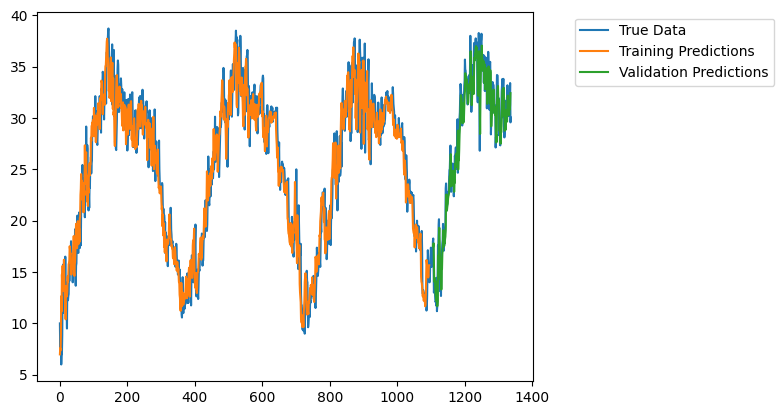

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='selu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
valScore = model.evaluate(valX, valY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (valScore, math.sqrt(valScore)))


# generate predictions for training
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)


# shift test predictions for plotting
valPredictPlot = np.empty_like(np.concatenate((train, val), axis=0))
valPredictPlot[:, :] = np.nan
valPredictPlot[len(trainPredict)+(look_back*2)+1:len(np.concatenate((train, val), axis=0))-1, :] = valPredict


plt.plot(np.concatenate((train, val), axis=0), label = 'True Data')
plt.plot(trainPredict, label = 'Training Predictions')
plt.plot(valPredictPlot, label = 'Validation Predictions')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

### Final ANN Model

In [ ]:
finalModel = model

<a id="lstm"></a>
### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(val, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
testX = np.reshape(testX, (testX.shape[0], 1, 1))


In [ ]:
# create and fit the LSTM network
model3 = Sequential()
model3.add(LSTM(4, input_shape=(1,look_back), return_sequences=True))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
1100/1100 - 3s - loss: 608.7105 - 3s/epoch - 2ms/step
Epoch 2/30
1100/1100 - 1s - loss: 368.9178 - 1s/epoch - 1ms/step
Epoch 3/30
1100/1100 - 1s - loss: 246.0845 - 1s/epoch - 1ms/step
Epoch 4/30
1100/1100 - 1s - loss: 165.6505 - 1s/epoch - 1ms/step
Epoch 5/30
1100/1100 - 2s - loss: 111.2842 - 2s/epoch - 2ms/step
Epoch 6/30
1100/1100 - 1s - loss: 73.5325 - 1s/epoch - 1ms/step
Epoch 7/30
1100/1100 - 1s - loss: 47.1853 - 1s/epoch - 1ms/step
Epoch 8/30
1100/1100 - 1s - loss: 30.0116 - 1s/epoch - 1ms/step
Epoch 9/30
1100/1100 - 1s - loss: 19.3379 - 1s/epoch - 1ms/step
Epoch 10/30
1100/1100 - 1s - loss: 12.8508 - 1s/epoch - 1ms/step
Epoch 11/30
1100/1100 - 1s - loss: 8.8461 - 1s/epoch - 1ms/step
Epoch 12/30
1100/1100 - 1s - loss: 6.3573 - 1s/epoch - 1ms/step
Epoch 13/30
1100/1100 - 3s - loss: 4.9916 - 3s/epoch - 2ms/step
Epoch 14/30
1100/1100 - 3s - loss: 4.2398 - 3s/epoch - 3ms/step
Epoch 15/30
1100/1100 - 2s - loss: 3.7902 - 2s/epoch - 2ms/step
Epoch 16/30
1100/1100 - 2s - loss:

In [ ]:
# Estimate model performance
trainScore = model3.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
valScore = model3.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (valScore, math.sqrt(valScore)))


# # generate predictions for training
# trainPredict = model3.predict(trainX)
# valPredict = model3.predict(testX)


# # shift test predictions for plotting
# valPredictPlot = np.empty_like(np.concatenate((train, val), axis=0))
# valPredictPlot[:, :] = np.nan
# valPredictPlot[len(trainPredict)+(look_back*2)+1:len(np.concatenate((train, val), axis=0))-1, :] = valPredict


# # plot baseline and predictions
# plt.plot(df_temp)
# plt.show()
# plt.plot(trainPredict)
# plt.plot(valPredictPlot)
# plt.show()

Train Score: 9.30 MSE (3.05 RMSE)
Test Score: 11.56 MSE (3.40 RMSE)


### LSTM 16 units

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(val, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
testX = np.reshape(testX, (testX.shape[0], 1, 1))

# create and fit the LSTM network
model3 = Sequential()
model3.add(LSTM(16, input_shape=(1,look_back), return_sequences=True))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

# Estimate model performance
trainScore = model3.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
valScore = model3.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (valScore, math.sqrt(valScore)))


# # generate predictions for training
# trainPredict = model3.predict(trainX)
# valPredict = model3.predict(testX)


# # shift test predictions for plotting
# valPredictPlot = np.empty_like(np.concatenate((train, val), axis=0))
# valPredictPlot[:, :] = np.nan
# valPredictPlot[len(trainPredict)+(look_back*2)+1:len(np.concatenate((train, val), axis=0))-1, :] = valPredict


# # plot baseline and predictions
# plt.plot(df_temp)
# plt.show()
# plt.plot(trainPredict)
# plt.plot(valPredictPlot)
# plt.show()

Epoch 1/30
1100/1100 - 5s - loss: 384.4535 - 5s/epoch - 4ms/step
Epoch 2/30
1100/1100 - 2s - loss: 104.7137 - 2s/epoch - 1ms/step
Epoch 3/30
1100/1100 - 1s - loss: 37.8704 - 1s/epoch - 1ms/step
Epoch 4/30
1100/1100 - 1s - loss: 15.7231 - 1s/epoch - 1ms/step
Epoch 5/30
1100/1100 - 2s - loss: 8.7890 - 2s/epoch - 2ms/step
Epoch 6/30
1100/1100 - 1s - loss: 6.0689 - 1s/epoch - 1ms/step
Epoch 7/30
1100/1100 - 1s - loss: 4.5950 - 1s/epoch - 1ms/step
Epoch 8/30
1100/1100 - 1s - loss: 3.8085 - 1s/epoch - 1ms/step
Epoch 9/30
1100/1100 - 1s - loss: 3.4430 - 1s/epoch - 1ms/step
Epoch 10/30
1100/1100 - 1s - loss: 3.3270 - 1s/epoch - 1ms/step
Epoch 11/30
1100/1100 - 1s - loss: 3.2743 - 1s/epoch - 1ms/step
Epoch 12/30
1100/1100 - 1s - loss: 3.1174 - 1s/epoch - 1ms/step
Epoch 13/30
1100/1100 - 1s - loss: 3.0307 - 1s/epoch - 1ms/step
Epoch 14/30
1100/1100 - 2s - loss: 3.0226 - 2s/epoch - 2ms/step
Epoch 15/30
1100/1100 - 2s - loss: 3.0080 - 2s/epoch - 1ms/step
Epoch 16/30
1100/1100 - 1s - loss: 3.0404 -

<a id="testing"></a>
# Testing

Test Score: 2.13 MSE (1.46 RMSE)
8/8 [==============================] - 0s 3ms/step


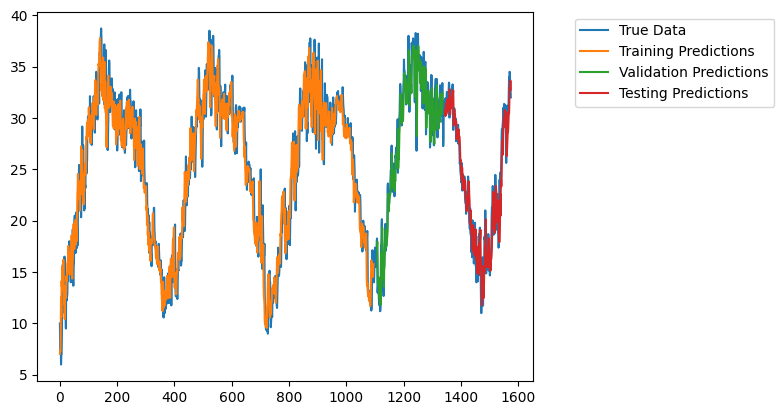

In [ ]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)


look_back = 5
testX, testY = create_dataset(test, look_back)

testScore = finalModel.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# generate predictions for training
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

# shift test predictions for plotting
testPredictPlot = np.empty_like(np.concatenate((train, val, test), axis=0))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(testPredictPlot) - len(testPredict):, :] = testPredict


# plot baseline and predictions
plt.plot(np.concatenate((train, val, test), axis=0), label = 'True Data')
plt.plot(trainPredict, label = 'Training Predictions')
plt.plot(valPredictPlot, label = 'Validation Predictions')
plt.plot(testPredictPlot, label = 'Testing Predictions')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
print(len(trainPredict))
print(len(valPredict))
print(len(testPredict))
print(len(testPredictPlot))

1096
230
231
1575
